In [4]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np


df = pd.read_csv("/Users/samuelescarfone/Desktop/Dat 300/project1/Predicting-Credit-Card-Defaults/data/Loan_default.csv", header=0)
df.head(5)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/py

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

# Cleaning & Preparing the Data

#### Convert Text Values into Integers

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for col in df:
    if df[col].dtype =='object':
        df[col] = encoder.fit_transform(df[col])

In [ ]:
target = 'Default'
print(df.isnull().sum())

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64


#### Remove Non-Categorical Data and Columns Highly Uncorrelated With Target

Let's check the correlation matrix to see which features are most strongly related to the target. This helps us identify what's actually important.

Unique values per column:
LoanID            255347
LoanAmount        158729
Income            114620
InterestRate        2301
CreditScore          550
MonthsEmployed       120
DTIRatio              81
Age                   52
LoanTerm               5
LoanPurpose            5
NumCreditLines         4
Education              4
EmploymentType         4
MaritalStatus          3
HasMortgage            2
HasDependents          2
HasCoSigner            2
Default                2
dtype: int64


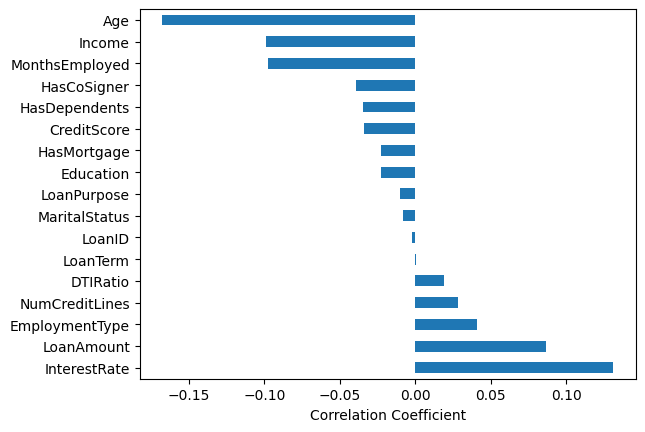

In [ ]:
corr = df.corr(numeric_only=True)
corr.head(10)
corr_with_default = corr['Default'].sort_values(ascending=False)

uniqueRows = df.nunique().sort_values(ascending=False)
print("Unique values per column:")
print(uniqueRows)

#Barplot
corr_with_default.drop('Default').plot(kind='barh')
plt.xlabel('Correlation Coefficient')
plt.show() 



I'm dropping `LoanID` because it's just a unique identifier and doesn't help with prediction. I'll keep the other numerical columns since they contain useful continuous data.

In [ ]:

df = df.drop(columns=['LoanID'])
df.dropna(inplace=True)

In [ ]:
df.head(5)

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,0,0,0,1,1,4,1,0
1,69,50432,124440,458,15,1,4.81,60,0.68,2,0,1,0,0,4,1,0
2,46,84208,129188,451,26,3,21.17,24,0.31,2,3,0,1,1,0,0,1
3,32,31713,44799,743,0,3,7.07,24,0.23,1,0,1,0,0,1,0,0
4,60,20437,9139,633,8,4,6.51,48,0.73,0,3,0,0,1,0,0,0


In [ ]:
df[target].value_counts()

Default
0    225694
1     29653
Name: count, dtype: int64

In [ ]:
df.describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,1.494421,1.500096,0.999918,0.500014,0.500268,2.000501,0.500108,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,1.118826,1.117358,0.816051,0.500001,0.500001,1.412723,0.500001,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,2.000000,2.000000,2.000000,1.000000,1.000000,3.000000,1.000000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,3.000000,3.000000,2.000000,1.000000,1.000000,4.000000,1.000000,1.000000


# Native Bayes Model

- Randomize Data and Split into Train and Test Sets

In [ ]:
np.random.seed(1234)
randomize_data = df.sample(frac=1) 
train_size = int(0.8 * len(randomize_data))
training = randomize_data[:train_size].reset_index(drop=True)
testing = randomize_data[train_size:].reset_index(drop=True)
print("Training shape:", training.shape)
print("Testing size:", testing.shape)


Training shape: (204277, 17)
Testing size: (51070, 17)


In [ ]:
training[target].value_counts(normalize=True)

Default
0    0.88355
1    0.11645
Name: proportion, dtype: float64

In [ ]:
testing[target].value_counts(normalize=True)

Default
0    0.885158
1    0.114842
Name: proportion, dtype: float64

In [ ]:
trainX = training.iloc[:, :-1]
trainX = training.drop(columns=[target])

trainY = training[target]
colnames = trainX.columns

trainX.head(5)


,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,19,96809,44706,618,34,4,21.93,48,0.85,2,1,2,1,1,1,0
1,44,79687,224131,809,40,2,11.95,36,0.64,0,2,0,0,1,1,0
2,57,66216,74977,385,82,4,12.72,48,0.79,1,0,2,1,1,3,1
3,37,47620,21367,378,119,2,24.97,48,0.77,2,2,1,0,0,1,0
4,37,98140,239788,301,116,1,12.49,12,0.87,0,2,0,0,1,1,1


In [ ]:
testX = testing.iloc[:, :-1]
testX = testing.drop(columns=[target])

testY = testing[target]


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
trainBrnli = le.fit_transform(trainY)

trainBrnli[:5]

array([0, 0, 0, 1, 0])

#### Run Model on Training Data

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
trainX = enc.fit_transform(trainX)  
trainX = pd.DataFrame(trainX, columns=colnames)

trainX.head() 

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner
0,1.0,63743.0,22626.0,318.0,34.0,3.0,1993.0,3.0,75.0,2.0,1.0,2.0,1.0,1.0,1.0,0.0
1,26.0,50383.0,124043.0,509.0,40.0,1.0,995.0,2.0,54.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0
2,39.0,39879.0,39786.0,85.0,82.0,3.0,1072.0,3.0,69.0,1.0,0.0,2.0,1.0,1.0,3.0,1.0
3,19.0,25435.0,9296.0,78.0,119.0,1.0,2297.0,3.0,67.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0
4,19.0,64767.0,132917.0,1.0,116.0,0.0,1049.0,0.0,77.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0


Since our features are continuous numbers (like Income, Loan Amount), `GaussianNB` is the right choice here. It assumes the data follows a normal distribution.

In [ ]:
model = GaussianNB()  #create model object
model.fit(trainX,trainBrnli) 

GaussianNB()

In [ ]:
yhattrain = model.predict(trainX)

In [ ]:
pd.crosstab(yhattrain, trainY)

Default,0,1
row_0,,
0,180353,23513
1,136,275


In [ ]:
print("Accuracy: ", str(accuracy_score(yhattrain, trainBrnli)*100) + "%")

Accuracy:  88.4230725926071%


### Model Performance on Test Data

In [ ]:
print("testX shape:", testX.shape)
print("trainX shape:", trainX.shape)


testX shape: (51070, 16)
trainX shape: (204277, 16)


In [ ]:
testBrnli = le.transform(testY)

testX = enc.fit_transform(testX) 

testX = pd.DataFrame(testX, columns=colnames) 
yhattest = model.predict(testX)
yhattest[:9] 


array([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
acc = accuracy_score(yhattest, testBrnli)
print("Accuracy: "+str(acc*100)+"%")

Accuracy: 88.51576267867632%


Accuracy is useful, but I want to see the breakdown of errors. The confusion matrix will show us if we're missing actual defaults (False Negatives) or flagging good loans as bad (False Positives).

In [ ]:
confM = confusion_matrix(testBrnli, yhattest)
print('Confusion matrix\n', confM)
print('True Negatives = ', confM[0,0])
print('False Positives = ', confM[0,1])
print('False Negatives = ', confM[1,0])
print('True Positives = ', confM[1,1])

Confusion matrix
 [[45204     1]
 [ 5864     1]]
True Negatives =  45204
False Positives =  1
False Negatives =  5864
True Positives =  1


In [ ]:
pd.crosstab(yhattest, testY)
FNR  = confM[0,1] /(confM[1,1]+confM[0,1])
print(FNR)

0.5


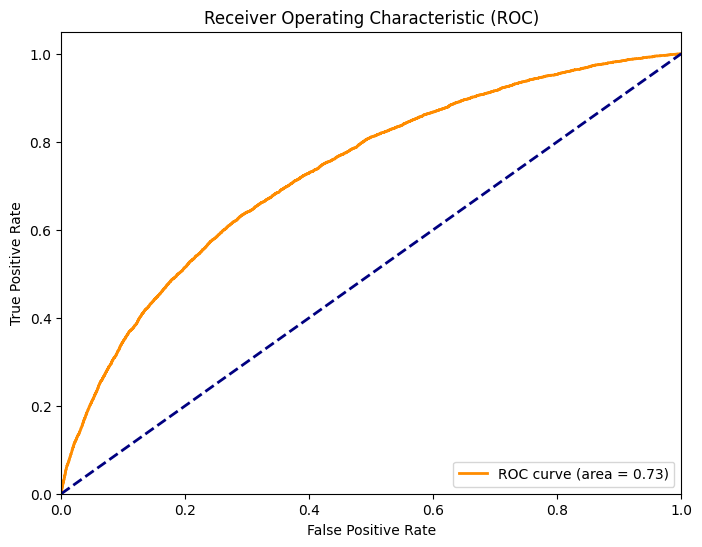

In [ ]:
yProb = model.predict_proba(testX)[:,1]
fpr, tpr, thresholds = roc_curve(testBrnli, yProb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report, precision_recall_curve
import numpy as np

# --- 1. SMOTE Implementation (Data Balancing) ---
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Resampled training set distribution:")
print(Counter(y_train_res)) 

# --- 2. Model Training ---
model_smote = GaussianNB()
model_smote.fit(X_train_res, y_train_res)

# --- 3. Threshold Optimization (The Key Fix) ---
# Naive Bayes outputs probabilities, which we use to find the best threshold.
y_proba = model_smote.predict_proba(X_test)[:, 1] # Get probability of Class 1 (Default)

# Calculate Precision and Recall for all possible thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Find the threshold that maximizes the F1-Score
f1_scores = 2 * (precision * recall) / (precision + recall)
optimal_threshold = thresholds[np.argmax(f1_scores)]

print(f"\nOptimal Prediction Threshold (maximizing F1-Score): {optimal_threshold:.4f}")

# --- 4. Prediction with Optimal Threshold ---
# Use the probabilities and the new threshold to get final predictions
y_pred_tuned = (y_proba >= optimal_threshold).astype(int)

# --- 5. Evaluate the results ---
print("\n--- Classification Report AFTER SMOTE & THRESHOLD TUNING ---")
# Set zero_division=0 to prevent warnings if the model doesn't predict one class
print(classification_report(y_test, y_pred_tuned, zero_division=0))

ImportError: cannot import name 'get_tags' from 'sklearn.utils' (/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/__init__.py)